# Defining Params

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import seaborn as sns
import pandas as pd
from keras.models import model_from_json
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
batch_size = 32
img_height=80
img_width = 256
approx_fold_size = 1000

# Load Model

In [4]:
path = "/home/nvidia/Downloads/"
model_definition_location = path+"/augmented_model_three_classes_unfrozen_layers_weighted_v2.json"
model_weights_location = path+"/augmented_model_three_classes_unfrozen_layers_weighted_v2.h5"
model_labels_location = path+"/augmented_model_three_classes_unfrozen_layers_weighted_v2_class_indices.json"
test_folder = "/home/nvidia/Downloads/soundflux_augmented/spectrograms/split/test/"

In [5]:
with open(model_definition_location, 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(model_weights_location)
with open(model_labels_location, 'r') as json_file:
    label_map = json.load(json_file)

# Evaluate Model

In [6]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range=10,
                            width_shift_range=0.1,
                            #horizontal_flip=True,
                            #vertical_flip=True,
                            fill_mode='nearest')

In [7]:
test_generator = datagen.flow_from_directory(test_folder,
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)

Found 4976 images belonging to 3 classes.


In [8]:
steps = np.ceil(len(test_generator.classes)/batch_size)

In [9]:
predictions = model.predict_generator(test_generator,
                                      steps = steps,
                              verbose=True)

156/156 [==============================] - 145s 926ms/step


# Confusion Matrix

In [10]:
y_pred = np.argmax(predictions, axis=1)

In [11]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

Confusion Matrix
[[ 591  121    1]
 [  97 1215   21]
 [   0    0 2930]]


In [12]:
normalized = cm/cm.sum(axis=1)[:, np.newaxis]

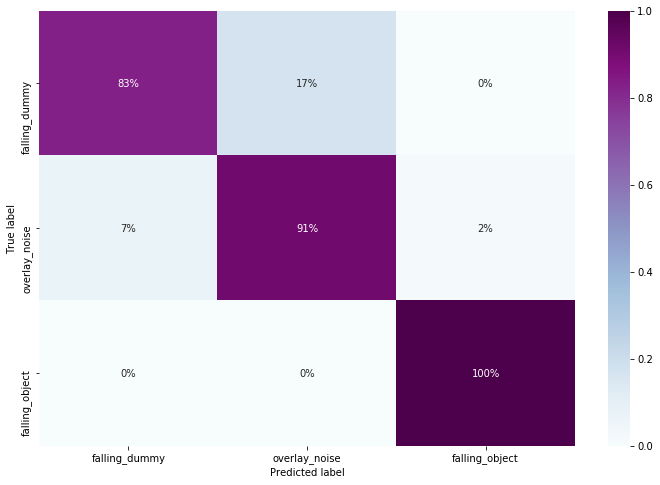

In [13]:
cm_df = pd.DataFrame(normalized,
                     index = test_generator.class_indices.keys(), 
                     columns = test_generator.class_indices.keys())

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, fmt='.0%', cmap="BuPu")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [14]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, 
                            target_names = test_generator.class_indices.keys()))

Classification Report
                precision    recall  f1-score   support

 falling_dummy       0.86      0.83      0.84       713
 overlay_noise       0.91      0.91      0.91      1333
falling_object       0.99      1.00      1.00      2930

     micro avg       0.95      0.95      0.95      4976
     macro avg       0.92      0.91      0.92      4976
  weighted avg       0.95      0.95      0.95      4976

